<a href="https://colab.research.google.com/github/fender-777/ADTA5900_Capstone/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Greg Allbee
#ADTA 5900
#Spring 2025
#Capstone Project - Higgs events with Machine Learning

###Install Lightning for quicker PyTorch model development

In [1]:
!pip install lightning --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

###Install Optuna for neural network optimization

In [2]:
!pip install optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.4 MB/s eta 0:00:00


###Mount Google Drive for Colab notebook access to data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Import necessary libraries

In [4]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import xgboost as xgb

import torch
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
#import pytorch_lightning as pl
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

import pickle

import optuna

import warnings
warnings.filterwarnings('ignore')
#from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC, ConfusionMatrix
import torchmetrics
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryAUROC, BinaryConfusionMatrix

###Import Higgs CSV, set column names, set target "class" as a Boolean

In [5]:
higgs_file = '/content/drive/MyDrive/ADTA5900/HIGGS/HIGGS.csv'
df = pd.read_csv(higgs_file, header=None,
                 names=['class',
                        'lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi',
                        'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag',
                        'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag',
                        'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag',
                        'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag',
                        'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb'],
                 dtype={'class':bool}
                 #nrows=100
                 )
df.head()

,class,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,True,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,True,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,True,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,False,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,True,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


###Use all features as inputs, target is the class

In [6]:
X = df.drop(['class'], axis=1)
y = df['class']

### Split training set, then split remainder into validation and test sets using 60/20/20 split

In [7]:
# 1. First split: Train (60%) and Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# 2. Second split: Validation (20%) and Test (20%) from the 40% temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

### Scale and fit features, transform validation and test sets

In [8]:
# 3. Scale the features based on training set
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print(X_train_scaled.head())
#print(X_val_scaled.head())
#print(X_test_scaled.head())

print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)

   lepton pT  lepton eta  lepton phi  missing energy magnitude  \
0  -0.702476   -1.323549   -0.520868                  1.738176   
1   0.502235   -0.134113    1.245024                  0.025672   
2   0.940165   -0.818618   -0.641053                  0.384152   
3   0.232292   -1.267553    0.798477                 -0.308646   
4   0.732367   -0.180455    0.127554                 -1.209051   

   missing energy phi  jet 1 pt  jet 1 eta  jet 1 phi  jet 1 b-tag  jet 2 pt  \
0            0.383517 -0.145774  -0.162011   1.420384     1.141393  0.188103   
1           -1.605022 -0.776591   0.481595  -0.588084     1.141393 -0.206918   
2           -0.560671  4.117547   1.580434   1.541084    -0.973048  5.450593   
3           -0.424677 -0.071118  -2.206637   1.091352    -0.973048 -0.344470   
4           -0.064092 -0.090216  -0.406307  -1.427474     1.141393 -1.260726   

   ...  jet 4 eta  jet 4 phi  jet 4 b-tag      m_jj     m_jjj      m_lv  \
0  ...  -0.615347   0.402066    -0.714309 -0.27

###Save scaler to pickle file

In [9]:
pickle.dump(scaler, open('/content/drive/MyDrive/ADTA5900/HIGGS/scaler.pkl', 'wb'))

In [10]:
# Placeholder to load scaler pickle file
#scaler = pickle.load(open('/content/drive/MyDrive/ADTA5900/HIGGS/scaler.pkl', 'rb'))

###Get statistical description of all input features

In [11]:
X_train_scaled.describe()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
count,6.600000e+06,6.600000e+06,6.600000e+06,6.600000e+06,6.600000e+06,6.600000e+06,6.600000e+06,6.600000e+06,6.600000e+06,6.600000e+06,...,6.600000e+06,6.600000e+06,6.600000e+06,6.600000e+06,6.600000e+06,6.600000e+06,6.600000e+06,6.600000e+06,6.600000e+06,6.600000e+06
mean,4.587307e-17,1.580204e-17,-4.257335e-18,1.348780e-15,-2.672071e-17,-8.053679e-17,1.855270e-17,-2.292254e-17,1.489577e-16,4.339694e-17,...,-5.156818e-18,-3.570100e-17,4.336733e-17,-2.049125e-16,8.655272e-17,-2.787567e-16,7.179765e-17,5.128396e-17,1.773601e-16,-1.670330e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.267933e+00,-2.413543e+00,-1.731509e+00,-1.663945e+00,-1.732913e+00,-1.797281e+00,-2.942467e+00,-1.731153e+00,-9.730483e-01,-1.608132e+00,...,-2.477674e+00,-1.732143e+00,-7.143089e-01,-1.422797e+00,-2.076332e+00,-5.884227e+00,-2.144982e+00,-1.757936e+00,-2.021658e+00,-1.956117e+00
25%,-7.089496e-01,-7.326928e-01,-8.665313e-01,-7.030861e-01,-8.659921e-01,-6.569867e-01,-6.810166e-01,-8.631038e-01,-9.730483e-01,-6.724778e-01,...,-7.087114e-01,-8.663694e-01,-7.143089e-01,-3.613888e-01,-4.692700e-01,-3.938267e-01,-6.093514e-01,-5.696626e-01,-5.850778e-01,-6.047913e-01
50%,-2.444785e-01,8.459093e-05,-4.479618e-04,-1.780563e-01,1.193823e-04,-2.024896e-01,-1.285970e-04,8.987175e-05,8.417221e-02,-2.049025e-01,...,1.955346e-04,-4.205998e-05,-7.143089e-01,-2.066339e-01,-1.945296e-01,-3.693463e-01,-2.346822e-01,-1.896181e-01,-2.345874e-01,-2.804431e-01
75%,4.329693e-01,7.318965e-01,8.657349e-01,4.912758e-01,8.660134e-01,3.789426e-01,6.817404e-01,8.631787e-01,1.141393e+00,4.186152e-01,...,7.082763e-01,8.658334e-01,1.500939e+00,-1.406471e-02,1.543620e-01,-1.829717e-01,3.336589e-01,3.149805e-01,2.944975e-01,3.176118e-01
max,1.964459e+01,2.413712e+00,1.731816e+00,1.974635e+01,1.732068e+00,1.654696e+01,2.942210e+00,1.731228e+00,1.141393e+00,1.974414e+01,...,2.478065e+00,1.732158e+00,1.500939e+00,5.808500e+01,5.084708e+01,4.222401e+01,3.335469e+01,3.196791e+01,2.866465e+01,2.368541e+01


###Check for null values

In [12]:
X_train_scaled.isna().sum()

,0
lepton pT,0
lepton eta,0
lepton phi,0
missing energy magnitude,0
missing energy phi,0
jet 1 pt,0
jet 1 eta,0
jet 1 phi,0
jet 1 b-tag,0
jet 2 pt,0


In [13]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6600000 entries, 0 to 6599999
Data columns (total 28 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   lepton pT                 float64
 1   lepton eta                float64
 2   lepton phi                float64
 3   missing energy magnitude  float64
 4   missing energy phi        float64
 5   jet 1 pt                  float64
 6   jet 1 eta                 float64
 7   jet 1 phi                 float64
 8   jet 1 b-tag               float64
 9   jet 2 pt                  float64
 10  jet 2 eta                 float64
 11  jet 2 phi                 float64
 12  jet 2 b-tag               float64
 13  jet 3 pt                  float64
 14  jet 3 eta                 float64
 15  jet 3 phi                 float64
 16  jet 3 b-tag               float64
 17  jet 4 pt                  float64
 18  jet 4 eta                 float64
 19  jet 4 phi                 float64
 20  jet 4 b-tag             

##Create a scikit-learn LogisticRegression model

In [27]:
logreg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

logreg_model = LogisticRegression(random_state = 42, n_jobs = -1)

logreg_grid = RandomizedSearchCV(
    logreg_model,
    logreg_param_grid,
    cv=5,
    n_iter=25,
    scoring=['accuracy','f1','precision','recall','roc_auc'],
    refit='accuracy',
    verbose=3
    )
logreg_grid.fit(X_train_scaled, y_train)
print(f"Logistic Regression best parameters:  {logreg_grid.best_params_}")
print(f"Logistic Regression best score:  {logreg_grid.best_score_}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END C=10, solver=liblinear; accuracy: (test=0.642) f1: (test=0.688) precision: (test=0.640) recall: (test=0.743) roc_auc: (test=0.685) total time=  41.7s
[CV 2/5] END C=10, solver=liblinear; accuracy: (test=0.641) f1: (test=0.687) precision: (test=0.639) recall: (test=0.742) roc_auc: (test=0.684) total time=  42.5s
[CV 3/5] END C=10, solver=liblinear; accuracy: (test=0.641) f1: (test=0.687) precision: (test=0.639) recall: (test=0.742) roc_auc: (test=0.684) total time=  42.5s
[CV 4/5] END C=10, solver=liblinear; accuracy: (test=0.642) f1: (test=0.687) precision: (test=0.639) recall: (test=0.743) roc_auc: (test=0.684) total time=  42.9s
[CV 5/5] END C=10, solver=liblinear; accuracy: (test=0.642) f1: (test=0.687) precision: (test=0.640) recall: (test=0.743) roc_auc: (test=0.685) total time=  42.6s
[CV 1/5] END C=0.01, solver=saga; accuracy: (test=0.642) f1: (test=0.688) precision: (test=0.640) recall: (test=0.743) roc_

In [28]:
logreg_best = logreg_grid.best_estimator_
pickle.dump(logreg_best, open('/content/drive/MyDrive/ADTA5900/HIGGS/logreg_best.pkl', 'wb'))

In [29]:
# Placeholder if needed to load model later
#logreg_best = pickle.load(open('/content/drive/MyDrive/ADTA5900/HIGGS/logreg_best.pkl', 'rb'))

In [30]:
logreg_y_preds = logreg_best.predict(X_test_scaled)

In [31]:
logreg_roc_auc = roc_auc_score(y_test, logreg_y_preds)
print(f"ROC-AUC Score: {logreg_roc_auc}")

logreg_accuracy = accuracy_score(y_test, logreg_y_preds)
print(f"Accuracy: {logreg_accuracy}")

logreg_precision = precision_score(y_test, logreg_y_preds)
print(f"Precision: {logreg_precision}")

logreg_recall = recall_score(y_test, logreg_y_preds)
print(f"Recall: {logreg_recall}")

logreg_f1 = f1_score(y_test, logreg_y_preds)
print(f"F1: {logreg_f1}")

ROC-AUC Score: 0.6351823553477886
Accuracy: 0.6416240909090909
Precision: 0.6392994371135923
Recall: 0.7428316795674132
F1: 0.6871878780328425


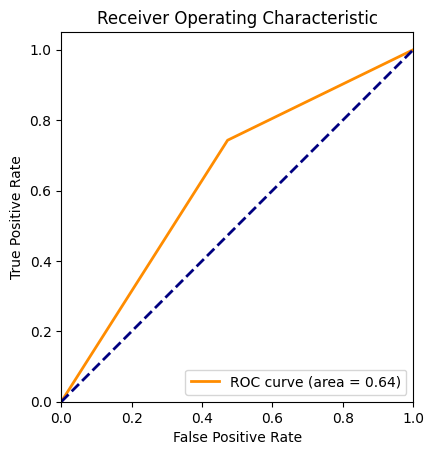

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, logreg_y_preds)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot(color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('/content/drive/MyDrive/ADTA5900/HIGGS/logreg_roc.png')
plt.show()

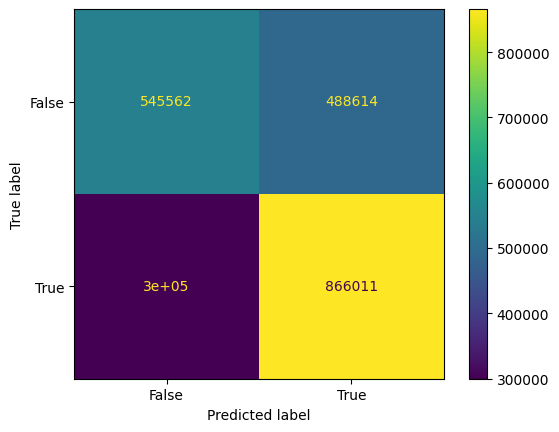

In [33]:
np.set_printoptions(precision=2)

logreg_matrix = confusion_matrix(y_test, logreg_y_preds)
logreg_disp = ConfusionMatrixDisplay(confusion_matrix=logreg_matrix, display_labels=logreg_best.classes_)
logreg_disp.plot()
plt.savefig('/content/drive/MyDrive/ADTA5900/HIGGS/logreg_matrix.png')
plt.show()

##Random Forest Classifier

In [14]:
random_forest_param_grid = {'n_estimators': np.arange(10, 50, 10),
                            'max_depth': np.arange(3, 11, 1),
                            'min_samples_split': np.arange(2, 11, 1)
                            }
random_forest_grid = RandomizedSearchCV(
    RandomForestClassifier(),
    random_forest_param_grid,
    cv=5,
    n_iter=20,
    random_state=42,
    scoring=['accuracy','f1','precision','recall','roc_auc'],
    refit='accuracy',
    verbose=3,
    n_jobs=-1
    )

random_forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([10, 20, 30, 40])},
                   random_state=42, refit='accuracy',
                   scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
                   verbose=3)

###Best parameters and scoring for Random Forest

In [15]:
print(f"Best Parameters from random search:  {random_forest_grid.best_params_}")
print(f"Best Score: {random_forest_grid.best_score_}")
random_forest = random_forest_grid.best_estimator_
pickle.dump(random_forest, open('/content/drive/MyDrive/ADTA5900/HIGGS/random_forest.pkl', 'wb'))

random_forest_y_preds = random_forest.predict(X_test)

Best Parameters from random search:  {'n_estimators': np.int64(40), 'min_samples_split': np.int64(8), 'max_depth': np.int64(10)}
Best Score: 0.7099675757575757


In [16]:
# Placeholder if needed to load Random Forest model again
#random_forest = pickle.load(open('/content/drive/MyDrive/ADTA5900/HIGGS/random_forest.pkl', 'rb'))

In [17]:
random_forest_roc = roc_auc_score(y_test, random_forest_y_preds)
print(f"Best estimator ROC: {random_forest_roc}")

random_forest_accuracy = accuracy_score(y_test, random_forest_y_preds)
print(f"Accuracy: {random_forest_accuracy}")

random_forest_precision = precision_score(y_test, random_forest_y_preds)
print(f"Precision: {random_forest_precision}")

random_forest_recall = recall_score(y_test, random_forest_y_preds)
print(f"Recall: {random_forest_recall}")

random_forest_f1 = f1_score(y_test, random_forest_y_preds)
print(f"F1: {random_forest_f1}")

Best estimator ROC: 0.707526300945645
Accuracy: 0.7104395454545455
Precision: 0.7141851469307572
Recall: 0.7562101998243302
F1: 0.7345971188822493


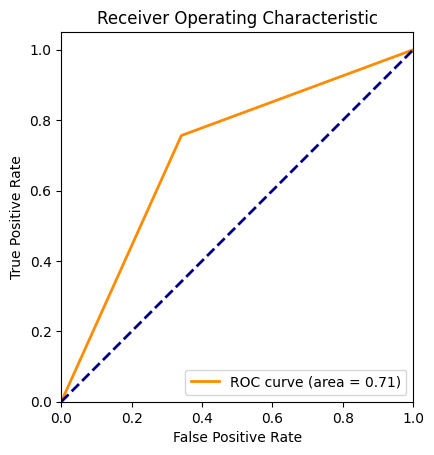

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, random_forest_y_preds)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest Classifier')
display.plot(color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('/content/drive/MyDrive/ADTA5900/HIGGS/random_forest_roc.png')
plt.show()

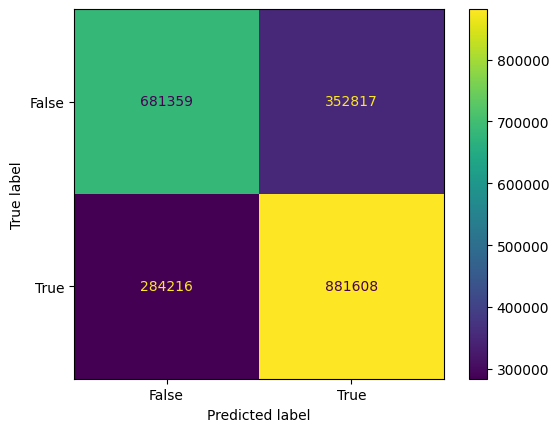

In [19]:
random_forest_matrix = confusion_matrix(y_test, random_forest_y_preds)
random_forest_disp = ConfusionMatrixDisplay(confusion_matrix=random_forest_matrix, display_labels=random_forest.classes_)
random_forest_disp.plot()
plt.savefig('/content/drive/MyDrive/ADTA5900/HIGGS/random_forest_matrix.png')
plt.show()

##XGBoost Classifier

In [20]:
xgb_param_grid = {'n_estimators': np.arange(10, 200, 10),
                  'max_depth': np.arange(3, 11, 1),
                  'learning_rate': np.arange(0.1, 0.5, 0.1)
                  }

#bst = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, verbosity=2, device="cuda", objective='binary:logistic')
xgb_grid = RandomizedSearchCV(xgb.XGBClassifier(device="cuda", objective='binary:logistic'), xgb_param_grid, cv=5, n_iter=20, random_state=42, scoring=['accuracy','f1','precision','recall','roc_auc'], refit='roc_auc', verbose=3, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_ra...
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
                   random_state=42, refit='roc_auc',
                   scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
                   verbose=3)

###XGBoost model best parameters, save model to JSON

In [21]:
print(f"Best Parameters from random search:  {xgb_grid.best_params_}")
print(f"Best Score: {xgb_grid.best_score_}")
xgb_best = xgb_grid.best_estimator_
xgb_best.save_model('/content/drive/MyDrive/ADTA5900/HIGGS/xgb_best.json')

Best Parameters from random search:  {'n_estimators': np.int64(130), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.30000000000000004)}
Best Score: 0.8397618332689307


###Code for loading XGBoost model

In [22]:
# Placeholder for loading XGBoost model
#xgb_best = xgb.XGBClassifier()
#xgb_best.load_model('/content/drive/MyDrive/ADTA5900/HIGGS/xgb_best.json')

###Predict from test set

In [23]:
xgb_preds = xgb_best.predict(X_test)

In [24]:
xgb_roc = roc_auc_score(y_test, xgb_preds)
print(f"Best estimator ROC: {xgb_roc}")

xgb_accuracy = accuracy_score(y_test, xgb_preds)
print(f"Accuracy: {xgb_accuracy}")

xgb_precision = precision_score(y_test, xgb_preds)
print(f"Precision: {xgb_precision}")

xgb_recall = recall_score(y_test, xgb_preds)
print(f"Recall: {xgb_recall}")

xgb_f1 = f1_score(y_test, xgb_preds)
print(f"F1: {xgb_f1}")

Best estimator ROC: 0.7560756820669737
Accuracy: 0.7576140909090909
Precision: 0.7657273007575586
Recall: 0.7817843859793588
F1: 0.7736725386709788


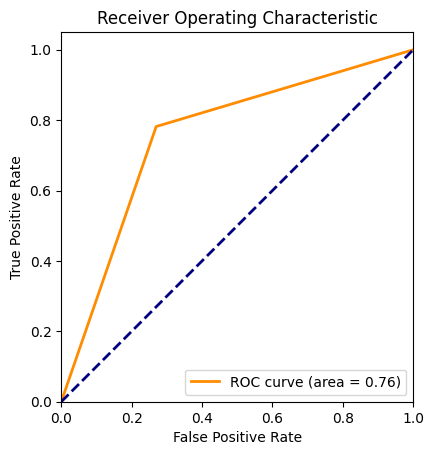

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, xgb_preds)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBoost Tree')
display.plot(color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('/content/drive/MyDrive/ADTA5900/HIGGS/xgb_roc.png')
plt.show()

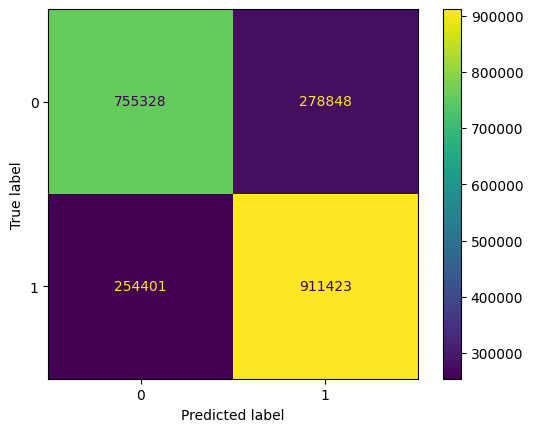

In [26]:
xgb_matrix = confusion_matrix(y_test, xgb_preds)
xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_matrix, display_labels=xgb_best.classes_)
xgb_disp.plot()
plt.savefig('/content/drive/MyDrive/ADTA5900/HIGGS/xgb_matrix.png')
plt.show()

##Deep feed-forward neural network

### Create PyTorch dataset and dataloaders for train and test data

In [27]:
# 4. Convert to PyTorch TensorDatasets
train_ds = TensorDataset(
    torch.from_numpy(X_train_scaled.values).float(),
    torch.from_numpy(y_train.values.reshape(-1, 1)).float()
)

val_ds = TensorDataset(
    torch.from_numpy(X_val_scaled.values).float(),
    torch.from_numpy(y_val.values.reshape(-1, 1)).float()
)

test_ds = TensorDataset(
    torch.from_numpy(X_test_scaled.values).float(),
    torch.from_numpy(y_test.values.reshape(-1, 1)).float()
)

# 5. Create DataLoaders
train_dl = DataLoader(train_ds, batch_size=2048, shuffle=True, drop_last=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=2048, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=2048, shuffle=False, num_workers=2, pin_memory=True)

In [28]:
class HiggsNet(L.LightningModule):
    def __init__(self, input_dim):
        super().__init__()
        self.save_hyperparameters()

        self.fc1 = nn.Linear(input_dim, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, 300)
        self.fc4 = nn.Linear(300, 300)
        self.fc5 = nn.Linear(300, 300)
        self.output = nn.Linear(300, 1)
        self.dropout = nn.Dropout(0.1)

        self.loss_fn = nn.BCEWithLogitsLoss()

        self.train_metrics = torchmetrics.MetricCollection (
            {
                "accuracy": BinaryAccuracy(),
                "precision": BinaryPrecision(),
                "recall": BinaryRecall(),
                "f1": BinaryF1Score(),
                "auroc": BinaryAUROC()
            },
            prefix="train_"
        )
        self.valid_metrics = self.train_metrics.clone(prefix="valid_")
        self.test_metrics = self.train_metrics.clone(prefix="test_")

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.dropout(x)
      x = F.relu(self.fc3(x))
      x = self.dropout(x)
      x = F.relu(self.fc4(x))
      x = self.dropout(x)
      x = F.relu(self.fc5(x))
      x = self.dropout(x)
      return self.output(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.sigmoid(logits)
        metrics = self.train_metrics(preds, y)
        self.log("train_loss", loss, on_step = False, on_epoch = True, prog_bar = True)
        self.log_dict(metrics, on_step = False, on_epoch = True, prog_bar = True)
        return loss

    def on_train_epoch_end(self):
        self.train_metrics.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.sigmoid(logits)
        self.valid_metrics.update(preds, y)

    def on_validation_epoch_end(self):
        metrics = self.valid_metrics.compute()
        self.log_dict(metrics, prog_bar = True)
        self.valid_metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.sigmoid(logits)
        self.test_metrics.update(preds, y)

    def on_test_epoch_end(self):
        metrics = self.test_metrics.compute()
        self.log_dict(metrics)
        self.test_metrics.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.05, weight_decay=0.00001)

In [29]:
early_stop_callback = EarlyStopping(
    monitor="valid_accuracy",
    min_delta=0.001,
    patience=10,
    verbose=True,
    mode="max")

lr_monitor = LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = ModelCheckpoint(
    dirpath='/content/drive/MyDrive/ADTA5900/HIGGS/checkpoints',
    filename='higgs-net_{epoch:02d}-{valid_accuracy:.2f}',
    save_top_k=1,
    verbose=True,
    monitor='valid_accuracy',
    mode='max')

logger = TensorBoardLogger('/content/drive/MyDrive/ADTA5900/HIGGS/lightning_logs', name='higgs-net')

In [31]:
#import glob

#ckpt_list = glob.glob('/content/drive/MyDrive/ADTA5900/HIGGS/lightning_logs/version_0/checkpoints/*.ckpt')
#print("Found checkpoints:", ckpt_list)

Found checkpoints: []


In [32]:
torch.set_float32_matmul_precision('medium')

higgs_model = HiggsNet(input_dim=X_train_scaled.shape[1])
trainer = L.Trainer(
    max_epochs=15,
    accelerator='gpu' if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[lr_monitor, early_stop_callback, checkpoint_callback],
    logger=logger,
    log_every_n_steps=3,
    enable_model_summary=True,
    enable_checkpointing=True
    )

trainer.fit(model=higgs_model, train_dataloaders=train_dl, val_dataloaders=val_dl) #, ckpt_path='/content/drive/MyDrive/ADTA5900/HIGGS/lightning_logs/')
trainer.test(higgs_model, dataloaders=test_dl)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name          | Type              | Params | Mode 
-------------------------------------------------------------
0  | fc1           | Linear            | 8.7 K  | train
1  | fc2           | Linear            | 90.3 K | train
2  | fc3           | Linear            | 90.3 K | train
3  | fc4           | Linear            | 90.3 K | train
4  | fc5           | Linear            | 90.3 K | train
5  | output        | Linear            | 301    | train
6  | dropout       | Dropout 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

In [ ]:
higgs_best = HiggsNet.load_from_checkpoint(checkpoint_callback.best_model_path)